### Create_kinetic_H_mesh

create_vrvxmesh.py: calc. v: 100%|██████████| 1/1 [00:00<?, ?it/s]


121 65
121 65
Tnorm: 77.19268204424908
0.07280683517456055


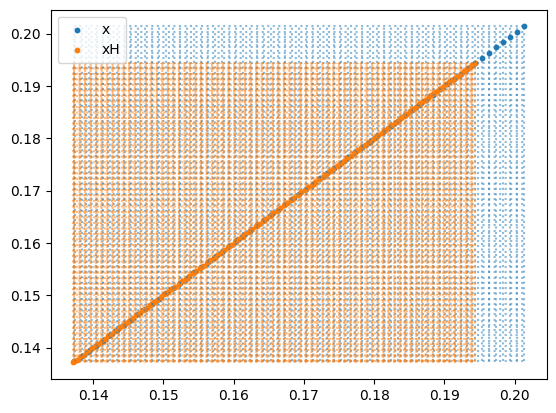

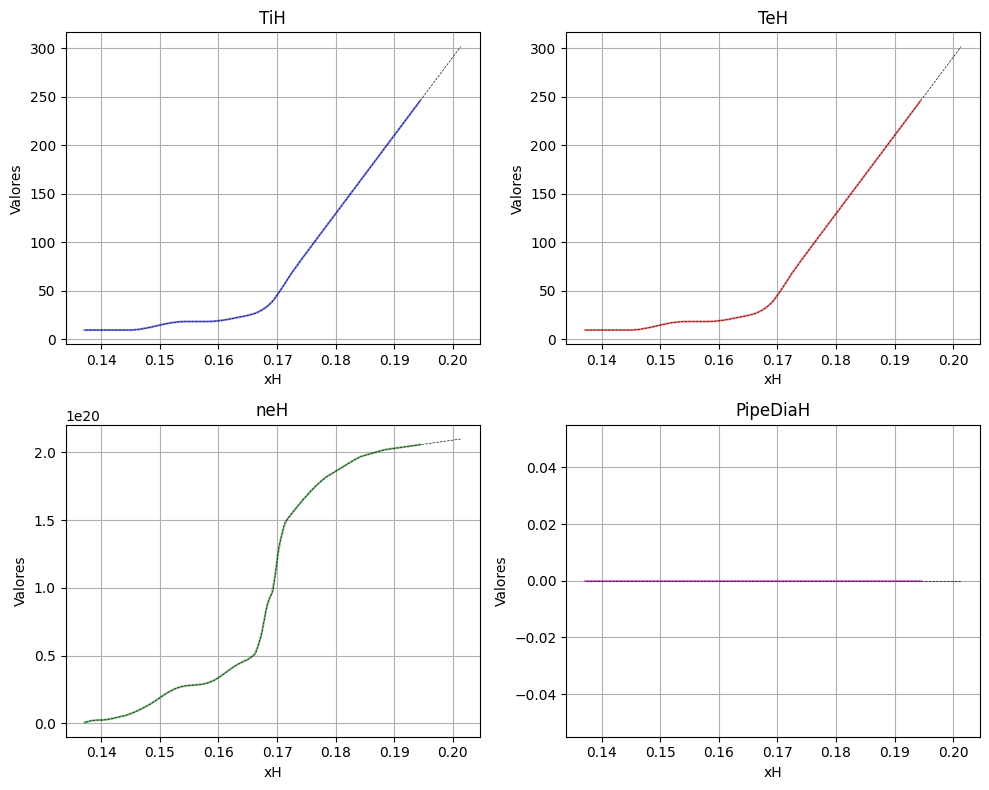

In [1]:
import numpy as np
from scipy.interpolate import interp1d

from p000_variables             import VARIABLES
from p002_Create_vr_vx_Mesh     import create_vr_vx_mesh
from p004_collrad_sigmav_ion_h0 import collrad_sigmav_ion_h0
from p005_jhs_coef              import JHS_Coef
from p006_sigmav_ion_h0         import sigma_v_ion_h0
from p008_sigmav_cx_h0          import sigma_v_cx_h0


def create_kinetic_H_mesh(    
    mu: float,
    x: np.ndarray,
    Ti: np.ndarray,
    Te: np.ndarray,
    n: np.ndarray,
    PipeDia: np.ndarray,
    nv: int = 20,
    fctr: float = 1.0,
    JH: int = 0,
    Use_collrad_ionization: int = 1,
    E0: np.ndarray = np.array([0.0])
    ) -> tuple:
    """
    Crea una malla refinada para cálculos cinéticos de hidrógeno.

    Inputs:
        mu (float): Masa reducida del sistema.
        x (np.ndarray): Coordenadas espaciales originales.
        Ti (np.ndarray): Temperatura iónica en las posiciones dadas por `x`.
        Te (np.ndarray): Temperatura electrónica en las posiciones dadas por `x`.
        n (np.ndarray): Densidad en las posiciones dadas por `x`.
        PipeDia (np.ndarray): Diámetro del tubo en las posiciones dadas por `x`.
        nv (int, opcional): Número de elementos deseados en la malla de velocidades radiales. Por defecto es 20.
        fctr (float, opcional): Factor de escala para ajustar el espaciado máximo de la malla. Por defecto es 1.0.
        JH (int, opcional): Bandera para elegir coeficientes de ionización basados en Johnson-Hinnov. Por defecto es 0.
        Use_collrad_ionization (int, opcional): Bandera para usar datos de ionización de COLLRAD. Por defecto es 1.

    Outputs:
        Tuple: Una tupla con los siguientes valores:
            - xH (np.ndarray): Nueva malla espacial refinada.
            - TiH (np.ndarray): Temperatura iónica interpolada en la nueva malla.
            - TeH (np.ndarray): Temperatura electrónica interpolada en la nueva malla.
            - neH (np.ndarray): Densidad interpolada en la nueva malla.
            - PipeDiaH (np.ndarray): Diámetro del tubo interpolado en la nueva malla.
            - vx (np.ndarray): Velocidades en la dirección x.
            - vr (np.ndarray): Velocidades radiales.
            - Tnorm (float): Temperatura normalizada.
            - ixE0 (Optional[int]): Índice correspondiente a E0 en la malla de velocidades vx.
            - irE0 (Optional[int]): Índice correspondiente a E0 en la malla de velocidades radiales vr.
    """
    # Inicializar índices opcionales
    ixE0, irE0 = None, None

    # Constantes físicas
    mH = VARIABLES.mH       # Masa del protón [kg]
    q  = VARIABLES.q        # Carga elemental [C]
        
    # Número de puntos en la malla original			
    nx = len(x)

    # Estas definiciones NO han sido usadas, es más, luego han sido redefinidas
    # # # Estimate interaction rate with side walls
    # # gamma_wall = np.zeros(nx, dtype=np.float64)

    # # # Estimate total reaction rate for destruction of hydrogen atoms and for interation with side walls
    RR = n*sigma_v_ion_h0(Te)

    # Set v0 to thermal speed of 10 eV neutral
    v0 = np.sqrt((2*10*q)/(mu*mH))
    
    # Calcular Y a partir de RR y v0
    y = np.zeros(nx, dtype=np.float64)
    for k in range(1,nx):
        y[k] = y[k-1] - 0.5*(x[k]-x[k-1])*(RR[k]+RR[k-1])/v0
    
    # Find x location where y = -5, i.e., where nH should be down by exp(-5)
    f_interp = interp1d(y, x, kind='linear', fill_value="extrapolate")
    xmaxH_interpolated = f_interp(-5.0)
    xmaxH = min(xmaxH_interpolated, max(x))
    xminH = x[0]


    # Interpolate Ti and Te onto a fine mesh between xminH and xmaxH
    xfine = np.linspace(xminH, xmaxH, 1001)

    Tifine      = interp1d(x, Ti,       kind='linear', fill_value="extrapolate")(xfine)
    Tefine      = interp1d(x, Te,       kind='linear', fill_value="extrapolate")(xfine)
    nfine       = interp1d(x, n,        kind='linear', fill_value="extrapolate")(xfine)
    PipeDiafine = interp1d(x, PipeDia,  kind='linear', fill_value="extrapolate")(xfine)

    # Setup a vx,vr mesh based on raw data to get typical vx, vr values
    vx, vr, Tnorm, ixE0, irE0 = create_vr_vx_mesh(nv, Tifine,E0=E0)
    vth     = np.sqrt((2*q*Tnorm)/(mu*mH))
    min_Vr  = vth*min(vr)
    minE0   = 0.5*mH*min_Vr*min_Vr/q

    # Estimate interaction rate with side walls
    nxfine = len(xfine)
    gamma_wall = np.zeros_like(xfine)

    max_vr  = np.max(vr)
    for k in range(0,nxfine):
        if PipeDiafine[k] > 0:
            gamma_wall[k] = (2*max_vr*vth)/PipeDiafine[k]
    # # gamma_wall = np.where(PipeDiafine > 0, (2 * max_vr * vth) / PipeDiafine, 0)  
    # # Using np.where instead of the loop doesn't significantly reduce computation time,  
    # # so I chose to keep the loop.
    # print(gamma_wall)
    
    # Estimate total reaction rate, including charge exchange and elastic scattering, and interaction with side walls
    if Use_collrad_ionization:
        ioniz_rate = collrad_sigmav_ion_h0(nfine,Tefine)[0]
    else:
        if JH:
            ioniz_rate = JHS_Coef(nfine,Tefine)
        else:
            ioniz_rate = sigma_v_ion_h0(Tefine)

    minE0_array = np.full_like(xfine, minE0)
    RR = (  (nfine * ioniz_rate) +
            (nfine * sigma_v_cx_h0(Tifine, minE0_array)) +
            (gamma_wall)
        )  

    # Compute local maximum grid spacing from dx_max = 2 min(vr) / RR
    big_dx = 0.02 * fctr
    dx_max = np.minimum(fctr * 0.8 * (2 * vth * np.min(vr) / RR), big_dx)

    # Construct xH axis 
    xpt = xmaxH
    xH = [xpt]
    dxh_max=0.0005
    f_dx_max = interp1d(xfine, dx_max, kind='linear', fill_value="extrapolate")

    while xpt > xminH:
        dxpt1 = f_dx_max(xpt)
        dxpt2 = dxpt1
        xpt_test = xpt - dxpt1
        
        if xpt_test > xminH:
            dxpt2 = f_dx_max(xpt_test)
        dxpt = min(dxpt1, dxpt2, dxh_max)
        xpt  = xpt - dxpt
        xH.append(xpt)        

    xH = xH[::-1]
    xH = [xminH] + xH[:-1]

    TiH      = interp1d(xfine, Tifine,      kind='linear', fill_value="extrapolate")(xH)
    TeH      = interp1d(xfine, Tefine,      kind='linear', fill_value="extrapolate")(xH)
    neH      = interp1d(xfine, nfine,       kind='linear', fill_value="extrapolate")(xH)
    PipeDiaH = interp1d(xfine, PipeDiafine, kind='linear', fill_value="extrapolate")(xH)


    vx, vr, Tnorm, ixE0, irE0 = create_vr_vx_mesh(nv, TiH,E0=E0)
    print(len(xH),len(x))
    print(len(TiH),len(Ti))
    return xH, TiH, TeH, neH, PipeDiaH, vx, vr, Tnorm, ixE0, irE0

if __name__=='__main__':
    import time
    from scipy.io import readsav

    start_time = time.time()
    data_file = readsav('1090904024_950to1050.sav')

    # nv = 20
    mu = data_file['mu']
    x = data_file['x']
    Ti = data_file['t_i']
    Te = data_file['t_e']
    n = data_file['n_e']
    PipeDia = data_file['d_pipe']

    # Llamada a la función
    xH, TiH, TeH, neH, PipeDiaH, vx, vr, Tnorm, ixE0, irE0 = create_kinetic_H_mesh(
        mu=mu,
        x=x,
        Ti=Ti,
        Te=Te,
        n=n,
        PipeDia=PipeDia
    )
    import matplotlib.pyplot as plt

    # Crear el gráfico de dispersión
    scatter1 = plt.scatter(x, x, s=10, label='x')
    scatter2 = plt.scatter(xH, xH, s=10, label='xH')

    # Obtener colores automáticamente asignados por scatter
    color_x = scatter1.get_facecolor()[0]  # Color del primer scatter
    color_xH = scatter2.get_facecolor()[0]  # Color del segundo scatter

    # Agregar grillas en las posiciones de x y xH con el mismo color de los puntos
    plt.vlines(x, ymin=min(x), ymax=max(x), colors=color_x, linestyles='dotted', alpha=0.5)
    plt.hlines(x, xmin=min(x), xmax=max(x), colors=color_x, linestyles='dotted', alpha=0.5)

    plt.vlines(xH, ymin=min(xH), ymax=max(xH), colors=color_xH, linestyles='dotted', alpha=0.5)
    plt.hlines(xH, xmin=min(xH), xmax=max(xH), colors=color_xH, linestyles='dotted', alpha=0.5)

    # Mostrar leyenda y gráfico
    plt.legend()

    print("Tnorm:", Tnorm)
    end_time = time.time()
    print(end_time-start_time)
    plt.show()

    fig, axs = plt.subplots(2, 2, figsize=(10,8))  # Crea una figura con una cuadrícula de 2x2

    axs[0, 0].plot(xH, TiH, label="TiH", color="b",alpha=0.5)
    axs[0, 0].plot(x, Ti, label="TiH", color="k",linestyle='--',linewidth=0.5,alpha=0.9)
    axs[0, 0].set_title("TiH")
    axs[0, 0].set_xlabel("xH")
    axs[0, 0].set_ylabel("Valores")
    axs[0, 0].grid(True)

    axs[0, 1].plot(xH, TeH, label="TeH", color="r",alpha=0.5)
    axs[0, 1].plot(x, Te, label="TeH", color="k",linestyle='--',linewidth=0.5,alpha=0.9)
    axs[0, 1].set_title("TeH")
    axs[0, 1].set_xlabel("xH")
    axs[0, 1].set_ylabel("Valores")
    axs[0, 1].grid(True)

    axs[1, 0].plot(xH, neH, label="neH", color="g",alpha=0.5)
    axs[1, 0].plot(x, n, label="neH", color="k",linestyle='--',linewidth=0.5,alpha=0.9)
    axs[1, 0].set_title("neH")
    axs[1, 0].set_xlabel("xH")
    axs[1, 0].set_ylabel("Valores")
    axs[1, 0].grid(True)

    axs[1, 1].plot(xH, PipeDiaH, label="PipeDiaH", color="m",alpha=0.5)
    axs[1, 1].plot(x, PipeDia, label="PipeDiaH", color="k",linestyle='--',linewidth=0.5,alpha=0.9)
    axs[1, 1].set_title("PipeDiaH")
    axs[1, 1].set_xlabel("xH")
    axs[1, 1].set_ylabel("Valores")
    axs[1, 1].grid(True)

    plt.tight_layout()  # Ajusta automáticamente los espacios entre subgráficos
    plt.show()


    # Imprimir resultados
    # print("xH:", xH)


In [2]:
# 

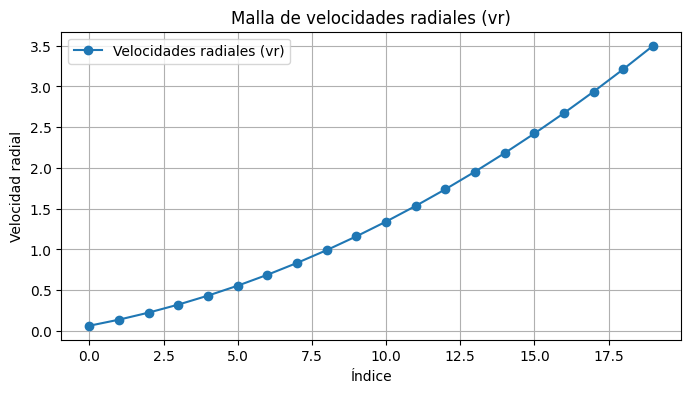

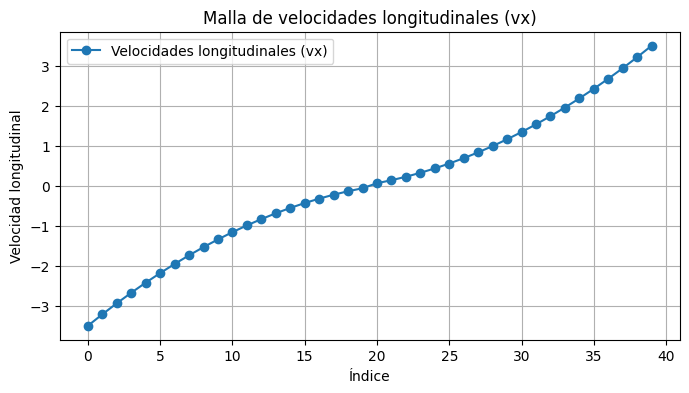

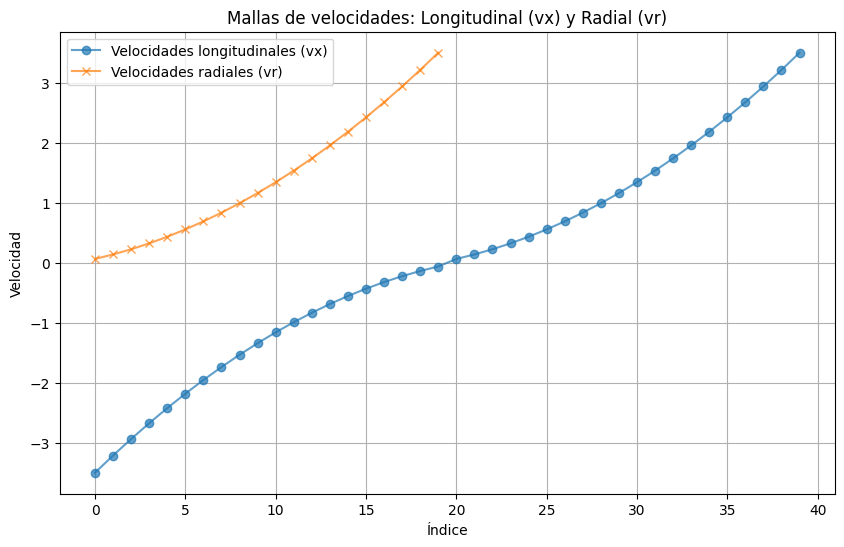

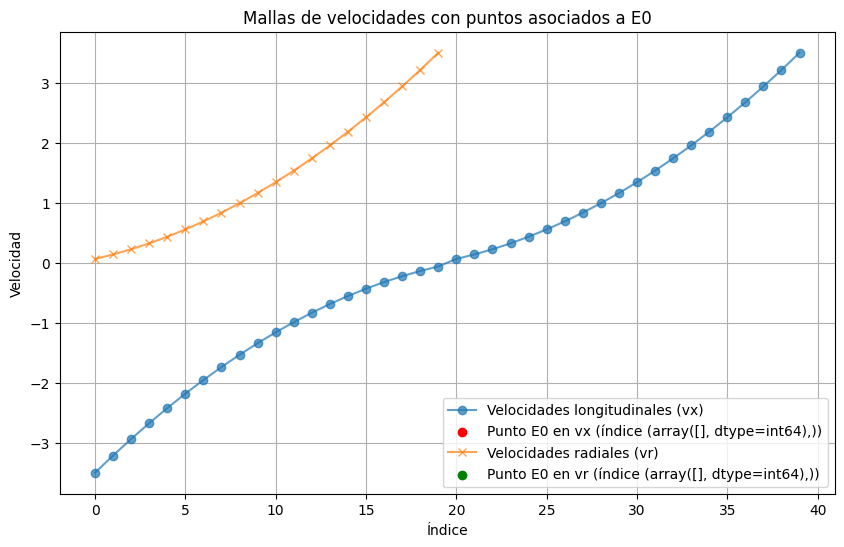

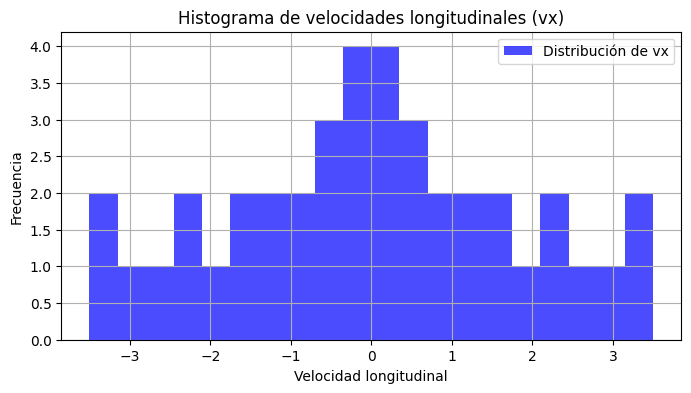

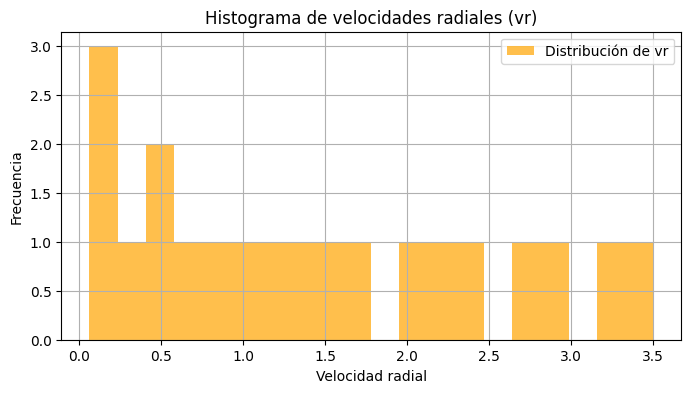

In [3]:
import matplotlib.pyplot as plt

# Supongamos que ya has llamado a create_vr_vx_mesh
# vx, vr, Tnorm, ixE0, irE0 = create_vr_vx_mesh(...)

# 1. Gráfico de vr
plt.figure(figsize=(8, 4))
plt.plot(vr, marker='o', label="Velocidades radiales (vr)")
plt.title("Malla de velocidades radiales (vr)")
plt.xlabel("Índice")
plt.ylabel("Velocidad radial")
plt.grid(True)
plt.legend()
plt.show()

# 2. Gráfico de vx
plt.figure(figsize=(8, 4))
plt.plot(vx, marker='o', label="Velocidades longitudinales (vx)")
plt.title("Malla de velocidades longitudinales (vx)")
plt.xlabel("Índice")
plt.ylabel("Velocidad longitudinal")
plt.grid(True)
plt.legend()
plt.show()

# 3. Gráfico combinado de vx y vr
plt.figure(figsize=(10, 6))
plt.plot(vx, label="Velocidades longitudinales (vx)", marker='o', alpha=0.7)
plt.plot(range(len(vr)), vr, label="Velocidades radiales (vr)", marker='x', alpha=0.7)
plt.title("Mallas de velocidades: Longitudinal (vx) y Radial (vr)")
plt.xlabel("Índice")
plt.ylabel("Velocidad")
plt.grid(True)
plt.legend()
plt.show()

# 4. Resaltar puntos asociados a E0
if ixE0 is not None and irE0 is not None:
    plt.figure(figsize=(10, 6))
    plt.plot(vx, label="Velocidades longitudinales (vx)", marker='o', alpha=0.7)
    plt.scatter(ixE0, vx[ixE0], color='red', label=f"Punto E0 en vx (índice {ixE0})", zorder=5)
    plt.plot(range(len(vr)), vr, label="Velocidades radiales (vr)", marker='x', alpha=0.7)
    plt.scatter(irE0, vr[irE0], color='green', label=f"Punto E0 en vr (índice {irE0})", zorder=5)
    plt.title("Mallas de velocidades con puntos asociados a E0")
    plt.xlabel("Índice")
    plt.ylabel("Velocidad")
    plt.grid(True)
    plt.legend()
    plt.show()

# 5. Histogramas
plt.figure(figsize=(8, 4))
plt.hist(vx, bins=20, color='blue', alpha=0.7, label="Distribución de vx")
plt.title("Histograma de velocidades longitudinales (vx)")
plt.xlabel("Velocidad longitudinal")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(vr, bins=20, color='orange', alpha=0.7, label="Distribución de vr")
plt.title("Histograma de velocidades radiales (vr)")
plt.xlabel("Velocidad radial")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.legend()
plt.show()

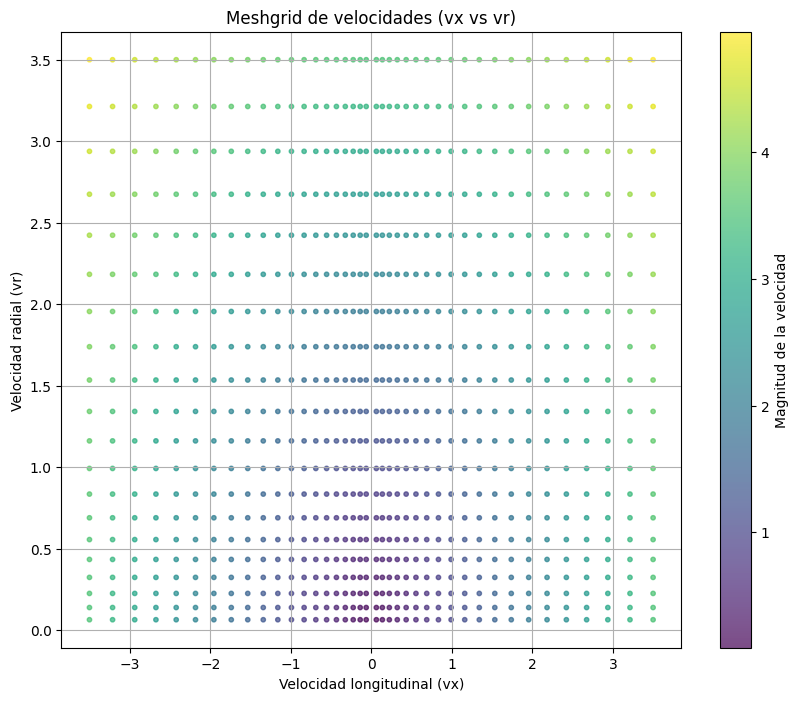

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que ya has llamado a create_vr_vx_mesh
# vx, vr, Tnorm, ixE0, irE0 = create_vr_vx_mesh(...)

# Crear el meshgrid
vx_grid, vr_grid = np.meshgrid(vx, vr)

# Calcular la magnitud de la velocidad en cada punto del meshgrid
velocity_magnitude = np.sqrt(vx_grid**2 + vr_grid**2)

# Visualizar el meshgrid con colores según la magnitud de la velocidad
plt.figure(figsize=(10, 8))
plt.scatter(vx_grid, vr_grid, c=velocity_magnitude, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(label="Magnitud de la velocidad")
plt.title("Meshgrid de velocidades (vx vs vr)")
plt.xlabel("Velocidad longitudinal (vx)")
plt.ylabel("Velocidad radial (vr)")
plt.grid(True)
plt.show()

In [5]:
# %matplotlib qt

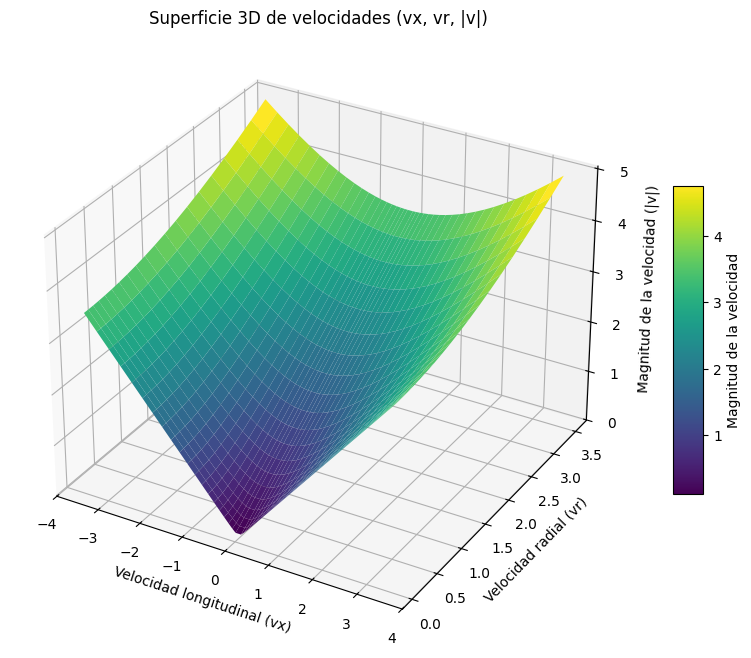

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Supongamos que ya has llamado a create_vr_vx_mesh
# vx, vr, Tnorm, ixE0, irE0 = create_vr_vx_mesh(...)

# Crear el meshgrid
vx_grid, vr_grid = np.meshgrid(vx, vr)

# Calcular la magnitud de la velocidad en cada punto del meshgrid
velocity_magnitude = np.sqrt(vx_grid**2 + vr_grid**2)

# Crear una figura 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar la superficie 3D
surf = ax.plot_surface(
    vx_grid, vr_grid, velocity_magnitude,
    cmap='viridis',  # Mapa de colores
    edgecolor='none'  # Sin bordes entre los cuadriláteros
)

# Añadir una barra de colores para la magnitud de la velocidad
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Magnitud de la velocidad")

# Etiquetas de los ejes
ax.set_title("Superficie 3D de velocidades (vx, vr, |v|)")
ax.set_xlabel("Velocidad longitudinal (vx)")
ax.set_ylabel("Velocidad radial (vr)")
ax.set_zlabel("Magnitud de la velocidad (|v|)")

# Mostrar el gráfico
plt.show()

In [7]:
%matplotlib inline

### Create_kinetic_H2_mesh

create_vrvxmesh.py: calc. v: 100%|██████████| 1/1 [00:00<?, ?it/s]


52 65
52 65
Tnorm: 13.753228166968162
0.0941319465637207


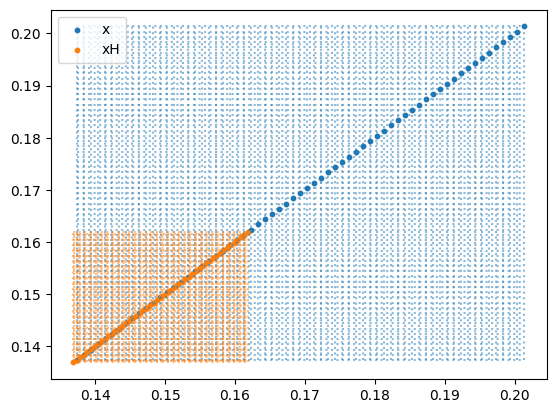

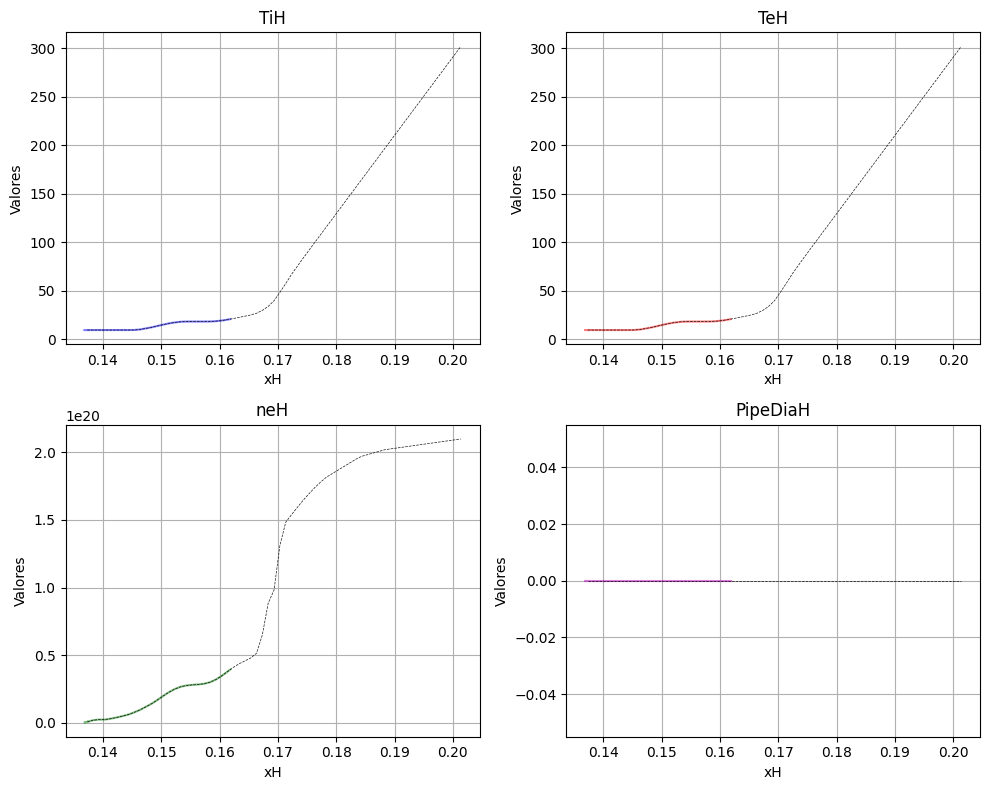

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

from p000_variables import VARIABLES
from p002_Create_vr_vx_Mesh import create_vr_vx_mesh
from p006_sigmav_ion_hh import sigma_v_ion_hh
from p008_sigmav_cx_hh import sigma_v_cx_hh
from p022_sigma_v_h1s_h1s_hh import sigma_v_h1s_h1s_hh
from p023_sigma_v_h1s_h2s_hh import sigma_v_h1s_h2s_hh


def create_kinetic_H2_mesh(
    mu:                     float,
    x:                      np.ndarray,
    Ti:                     np.ndarray,
    Te:                     np.ndarray,
    n:                      np.ndarray,
    PipeDia:                np.ndarray,
    nv:                     int     = 20,
    fctr:                   float   = 1.0,
    JH:                     int     = 0,
    Use_collrad_ionization: int     = 1,
    E0: np.ndarray = np.array([0.0])
    ) -> tuple:
    
    # Constantes físicas
    mH  = VARIABLES.mH       # Masa del protón [kg]
    q   = VARIABLES.q        # Carga elemental [C]
    k_b = VARIABLES.k_b      # Constante de Boltzmann [J/K]
    
    Twall=293.0*(k_b/q)      # Room Temperature [eV]
    v0_bar=np.sqrt(8.0*Twall*q/(np.pi*2*mu*mH)) # Rapidez Térmica promedio de una molécula [m/s]
    
    nx = len(x)
    # Estimate interaction rate with side walls
    gamma_wall = np.zeros(nx, dtype=np.float64)

    # RR=n*sigmav_ion_HH(Te)+n*sigmav_H1s_H1s_HH(Te)+n*sigmav_H1s_H2s_HH(Te)
    RR = ((n*sigma_v_ion_hh(Te)) + 
          (n*sigma_v_h1s_h1s_hh(Te)['sigma_v']) + 
          (n*sigma_v_h1s_h2s_hh(Te)['sigma_v'])
         )
    
    # Calcular Y a partir de RR y v0        
    y = np.zeros(nx, dtype=np.float64)
    for k in range(1,nx):
        y[k] = y[k-1] - 0.5*(x[k]-x[k-1])*(RR[k]+RR[k-1])/v0_bar

    # Find x location where Y = -10, i.e., where nH2 should be down by exp(-10)
    f_interp = interp1d(y, x, kind='linear', fill_value="extrapolate")
    xmaxH2_interpolated = f_interp(-10.0)
    xmaxH2 = min(xmaxH2_interpolated, max(x))
    xminH2 = x[0]
    
    # Interpolate Ti and Te onto a fine mesh between xminH2 and xmaxH2
    xfine = np.linspace(xminH2, xmaxH2, 1001)
    Tifine      = interp1d(x, Ti,       kind='linear', fill_value="extrapolate")(xfine)
    Tefine      = interp1d(x, Te,       kind='linear', fill_value="extrapolate")(xfine)
    nfine       = interp1d(x, n,        kind='linear', fill_value="extrapolate")(xfine)
    PipeDiafine = interp1d(x, PipeDia,  kind='linear', fill_value="extrapolate")(xfine)   
    
    # Setup a vx,vr mesh based on raw data to get typical vx, vr values
    vx, vr, Tnorm, ixE0, irE0 = create_vr_vx_mesh(nv, Tifine,E0=E0)
    vth     = np.sqrt((2*q*Tnorm)/(mu*mH))

    # Estimate interaction rate with side walls
    nxfine = len(xfine)
    gamma_wall = np.zeros_like(xfine)

    max_vr  = np.max(vr)
    for k in range(0,nxfine):
        if PipeDiafine[k] > 0:
            gamma_wall[k] = (2*max_vr*vth)/PipeDiafine[k]

    RR = (
            (nfine*sigma_v_ion_hh(Tefine)) +
            (nfine*sigma_v_h1s_h1s_hh(Tefine)['sigma_v']) +
            (nfine*sigma_v_h1s_h2s_hh(Tefine)['sigma_v']) +
            (nfine*sigma_v_cx_hh(Tifine, Tifine)*0.1) +
            gamma_wall
          )
    
    # Compute local maximum grid spacing from dx_max = 2 min(vr) / RR
    big_dx = 0.02 * fctr
    dx_max = np.minimum(fctr * 0.8 * (2 * vth * np.min(vr) / RR), big_dx)   

    xpt = xmaxH2
    xH2 = [xpt]
    f_dx_max = interp1d(xfine, dx_max, kind='linear', fill_value="extrapolate")
    dxh_max=0.0005
    while xpt > xminH2:
        dxpt1 = f_dx_max(xpt)
        dxpt2 = dxpt1
        xpt_test = xpt - dxpt1

        if xpt_test > xminH2:
            dxpt2 = f_dx_max(xpt_test)
        dxpt = min(dxpt1, dxpt2,dxh_max)
        xpt = xpt - dxpt
        xH2.append(xpt)
    
    xH2 = xH2[::-1]
    xH2 = [xminH2] + xH2[:-1]

    TiH2      = interp1d(xfine, Tifine,      kind='linear', fill_value="extrapolate")(xH2)
    TeH2      = interp1d(xfine, Tefine,      kind='linear', fill_value="extrapolate")(xH2)
    neH2      = interp1d(xfine, nfine,       kind='linear', fill_value="extrapolate")(xH2)
    PipeDiaH2 = interp1d(xfine, PipeDiafine, kind='linear', fill_value="extrapolate")(xH2)   

    vx, vr, Tnorm, ixE0, irE0 = create_vr_vx_mesh(nv, TiH2,E0=E0)

    print(len(xH2),len(x))
    print(len(TiH2),len(Ti))
    return xH2, TiH2, TeH2, neH2, PipeDiaH2, vx, vr, Tnorm, ixE0, irE0

if __name__=='__main__':
    import time
    from scipy.io import readsav

    start_time = time.time()
    data_file = readsav('1090904024_950to1050.sav')

    # nv = 20
    mu = data_file['mu']
    x = data_file['x']
    Ti = data_file['t_i']
    Te = data_file['t_e']
    n = data_file['n_e']
    PipeDia = data_file['d_pipe']

    # Llamada a la función
    xH2, TiH2, TeH2, neH2, PipeDiaH2, vx, vr, Tnorm, ixE0, irE0 = create_kinetic_H2_mesh(
        mu=mu,
        x=x,
        Ti=Ti,
        Te=Te,
        n=n,
        PipeDia=PipeDia
    )

    import matplotlib.pyplot as plt

    # Crear el gráfico de dispersión
    scatter1 = plt.scatter(x, x, s=10, label='x')
    scatter2 = plt.scatter(xH2, xH2, s=10, label='xH')

    # Obtener colores automáticamente asignados por scatter
    color_x = scatter1.get_facecolor()[0]  # Color del primer scatter
    color_xH = scatter2.get_facecolor()[0]  # Color del segundo scatter

    # Agregar grillas en las posiciones de x y xH con el mismo color de los puntos
    plt.vlines(x, ymin=min(x), ymax=max(x), colors=color_x, linestyles='dotted', alpha=0.5)
    plt.hlines(x, xmin=min(x), xmax=max(x), colors=color_x, linestyles='dotted', alpha=0.5)

    plt.vlines(xH2, ymin=min(xH2), ymax=max(xH2), colors=color_xH, linestyles='dotted', alpha=0.5)
    plt.hlines(xH2, xmin=min(xH2), xmax=max(xH2), colors=color_xH, linestyles='dotted', alpha=0.5)

    # Mostrar leyenda y gráfico
    plt.legend()

    print("Tnorm:", Tnorm)
    end_time = time.time()
    print(end_time-start_time)
    plt.show()

    fig, axs = plt.subplots(2, 2, figsize=(10,8))  # Crea una figura con una cuadrícula de 2x2

    axs[0, 0].plot(xH2, TiH2, label="TiH", color="b",alpha=0.5)
    axs[0, 0].plot(x, Ti, label="TiH", color="k",linestyle='--',linewidth=0.5,alpha=0.9)
    axs[0, 0].set_title("TiH")
    axs[0, 0].set_xlabel("xH")
    axs[0, 0].set_ylabel("Valores")
    axs[0, 0].grid(True)

    axs[0, 1].plot(xH2, TeH2, label="TeH", color="r",alpha=0.5)
    axs[0, 1].plot(x, Te, label="TeH", color="k",linestyle='--',linewidth=0.5,alpha=0.9)
    axs[0, 1].set_title("TeH")
    axs[0, 1].set_xlabel("xH")
    axs[0, 1].set_ylabel("Valores")
    axs[0, 1].grid(True)

    axs[1, 0].plot(xH2, neH2, label="neH", color="g",alpha=0.5)
    axs[1, 0].plot(x, n, label="neH", color="k",linestyle='--',linewidth=0.5,alpha=0.9)
    axs[1, 0].set_title("neH")
    axs[1, 0].set_xlabel("xH")
    axs[1, 0].set_ylabel("Valores")
    axs[1, 0].grid(True)

    axs[1, 1].plot(xH2, PipeDiaH2, label="PipeDiaH", color="m",alpha=0.5)
    axs[1, 1].plot(x, PipeDia, label="PipeDiaH", color="k",linestyle='--',linewidth=0.5,alpha=0.9)
    axs[1, 1].set_title("PipeDiaH")
    axs[1, 1].set_xlabel("xH")
    axs[1, 1].set_ylabel("Valores")
    axs[1, 1].grid(True)

    plt.tight_layout()  # Ajusta automáticamente los espacios entre subgráficos
    plt.show()